## Load Chronos Model

In [64]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from chronos import BaseChronosPipeline, Chronos2Pipeline, ChronosPipeline

# Check CUDA availability
print("="*60)
print("CUDA INFORMATION")
print("="*60)
print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"CUDA Version: {torch.version.cuda if torch.cuda.is_available() else 'N/A'}")
if torch.cuda.is_available():
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"  GPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"    Memory Allocated: {torch.cuda.memory_allocated(i) / 1024**3:.2f} GB")
        print(f"    Memory Cached: {torch.cuda.memory_reserved(i) / 1024**3:.2f} GB")
print("="*60)

# Set GPU if available (use GPU 0 by default, which is most common)
if torch.cuda.is_available():
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    device = "cuda:0"
else:
    device = "cpu"
    print("WARNING: CUDA not available, using CPU. Inference will be slower.")

# Load the Chronos-2 pipeline
print(f"\nLoading Chronos-2 pipeline on {device}...")
pipeline: ChronosPipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-2", 
    device_map=device,
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32  # Use FP16 on GPU for speed
)

print(f"✓ Chronos-2 pipeline loaded successfully on {device}!")

# Verify model is on correct device
if hasattr(pipeline, 'model'):
    model_device = next(pipeline.model.parameters()).device
    print(f"Model device: {model_device}")

%load_ext autoreload
%autoreload 2


CUDA INFORMATION
CUDA Available: True
CUDA Version: 12.1
Number of GPUs: 1
  GPU 0: NVIDIA GeForce RTX 2060 with Max-Q Design
    Memory Allocated: 0.23 GB
    Memory Cached: 0.91 GB

Loading Chronos-2 pipeline on cuda:0...
✓ Chronos-2 pipeline loaded successfully on cuda:0!
Model device: cuda:0
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
# IMM Model Dataset Configuration
# Generate IMM (composite) trajectories with CA, CV, and CT segments
# Each trajectory: 40 CA → 50 moderate CT → 60 CV → 50 aggressive CT (200 steps total)

from src.dataset.dataset_configurations import (
    DatasetConfig, ClassConfig, IMMSpec, SegmentSpec,
    CASpec, CVSpec, CTSpec,
    generate_dataset, quick_overlap_checks
)
import json

# Segment structure (same for all classes)
TRAJECTORY_STRUCTURE = [
    ('CA', 40),      # 40 steps of Constant Acceleration
    ('CT_MOD', 50),  # 50 steps of moderate CT
    ('CV', 60),      # 60 steps of Constant Velocity
    ('CT_AGG', 50),  # 50 steps of aggressive CT
]

# Base parameters
dt = 0.04
measurement_noises = [np.array([0.1, 0.1]), np.array([0.5, 0.5]), np.array([0.8, 0.8])]

# Omega parameters for CT segments
omega_moderate = 1.0  # rad/s
omega_aggressive = 3.0  # rad/s

omega_noise_low = 0.1  # rad/s STD
omega_noise_high = 2.0  # rad/s STD

# Process noise parameters
process_noise_low = np.array([0.05, 0.05])
process_noise_moderate = np.array([0.2, 0.2])
process_noise_high = np.array([1.0, 1.0])

# CA acceleration
ca_acceleration = np.array([2.0, 1.0])  # m/s^2
ca_accel_noise_low = np.array([0.05, 0.05])
ca_accel_noise_moderate = np.array([0.3, 0.3])
ca_accel_noise_high = np.array([1.0, 1.0])

# Helper function to create segment specifications
def create_segments(ca_noise, cv_noise, meas_noise):
    """Create the 4 segments: CA → CT_MOD → CV → CT_AGG"""
    segments = []
    for seg_type, seg_length in TRAJECTORY_STRUCTURE:
        spec = None
        if seg_type == 'CA':
            spec = CASpec(
                accel_noise_std=ca_noise,
                acceleration=ca_acceleration,
                measurement_noise_std=meas_noise
            )
        elif seg_type == 'CV':
            spec = CVSpec(
                vel_change_std=cv_noise,
                measurement_noise_std=meas_noise
            )
        elif seg_type == 'CT_MOD':
            spec = CTSpec(
                omega=omega_moderate,
                omega_noise_std=omega_noise_low,
                measurement_noise_std=meas_noise
            )
        elif seg_type == 'CT_AGG':
            spec = CTSpec(
                omega=omega_aggressive,
                omega_noise_std=omega_noise_high,
                measurement_noise_std=meas_noise
            )
        if spec is None:
            raise Exception(f"No proper segment was found for {seg_type}")
        segments.append(SegmentSpec(model_spec=spec, T=seg_length))
    return segments

classes = []

for observation_noise in measurement_noises:
    classes.append(ClassConfig(
        name=f"IMM_AllLowNoise_obs_{observation_noise[0]}",
        model_spec=IMMSpec(
            measurement_noise_std=observation_noise,
            segments=create_segments(
            ca_noise=ca_accel_noise_low, cv_noise=process_noise_low, meas_noise=observation_noise)),
        n_trajectories=20))
    
    # Class 2: ALL HIGH NOISE
    classes.append(ClassConfig(
        name=f"IMM_AllHighNoise_obs_{observation_noise[0]}",
        model_spec=IMMSpec(
            measurement_noise_std=observation_noise,
            segments=create_segments(
            ca_noise=ca_accel_noise_high, cv_noise=process_noise_high, meas_noise=observation_noise)),
        n_trajectories=20))
    
    # Class 3: ALL MODERATE NOISE
    classes.append(ClassConfig(
        name=f"IMM_AllModerateNoise_obs_{observation_noise[0]}",
        model_spec=IMMSpec(
            measurement_noise_std=observation_noise,
            segments=create_segments(
            ca_noise=ca_accel_noise_moderate, cv_noise=process_noise_moderate, meas_noise=observation_noise)),
        n_trajectories=20))
    
    # Class 4: HIGH CV + LOW CA
    classes.append(ClassConfig(
        name=f"IMM_HighCV_LowCA_obs_{observation_noise[0]}",
        model_spec=IMMSpec(
            measurement_noise_std=observation_noise,
            segments=create_segments(
            ca_noise=ca_accel_noise_low, cv_noise=process_noise_high, meas_noise=observation_noise)),
        n_trajectories=20))
    
    # Class 5: LOW CV + HIGH CA
    classes.append(ClassConfig(
        name=f"IMM_LowCV_HighCA_obs_{observation_noise[0]}",
        model_spec=IMMSpec(
            measurement_noise_std=observation_noise,
            segments=create_segments(
            ca_noise=ca_accel_noise_high, cv_noise=process_noise_low, meas_noise=observation_noise)),
        n_trajectories=20))

# Create IMM dataset configuration
imm_config = DatasetConfig(
    seed=42, dim=2, dt=dt, T=200,
    init_pos_range=(-50.0, 50.0), init_speed_range=(-20.0, 20.0),
    classes=classes, store_clean=True)

# Generate the dataset
imm_data = generate_dataset(imm_config)
print(f"Generated trajectories successfully!")

for class_name, class_data in imm_data.items():
    if class_name == "config":
        continue
    print(f"{class_name}: {len(class_data['X'])} trajectories")

Final state: TrajectoryState(position=array([-49.83260855,  -7.38556387]), velocity=array([-10.84915722,   2.99851478]), acceleration=array([1.90661347, 0.55566111]), omega=None, tau=None)
Final state: TrajectoryState(position=array([-63.9709783 , -19.48789384]), velocity=array([  1.28653941, -11.18213394]), acceleration=None, omega=np.float64(0.951425765408378), tau=None)
Final state: TrajectoryState(position=array([-60.18659832, -46.66569438]), velocity=array([  1.57225434, -11.58602289]), acceleration=None, omega=None, tau=None)
Final state: TrajectoryState(position=array([-59.51603432, -46.82598884]), velocity=array([-7.99857447, -8.52823057]), acceleration=None, omega=np.float64(0.8491120299988624), tau=None)
Final state: TrajectoryState(position=array([  4.16269254, -30.79556946]), velocity=array([-10.00443633,  -9.40275646]), acceleration=array([2.01247594, 0.87270836]), omega=None, tau=None)
Final state: TrajectoryState(position=array([  7.17678405, -53.40123654]), velocity=arr

## Prepare Data for Chronos-2
Chronos expects to get the data in a specific format. So here, we prepare the data to be in the format

## Batched Prediction ##

In [66]:
## 🎯 OPTIMAL: Multi-Trajectory Rolling Forecast with Batching

# This approach batches ACROSS trajectories while maintaining rolling forecast
import time

print("="*60)
print("MULTI-TRAJECTORY ROLLING FORECAST (BATCHED)")
print("="*60)

# Generate multiple trajectories
n_trajectories = 20

print(f"\nProcessing {n_trajectories} trajectories with rolling forecast")

# K-LAG PREDICTION SETUP
k = 5  # k-step ahead prediction
initial_context_length = 3  # Minimum context to start predictions

T_rolling = imm_data[list(imm_data.keys())[0]]['X'][0].shape[0]
n_predictions = T_rolling - initial_context_length - k

all_predictions = []

start_rolling = time.time()

print(f"K-LAG PREDICTION: k={k}, initial_context={initial_context_length}")
print(f"Will make {n_predictions} predictions from timestep {initial_context_length} to {T_rolling - k}")
print("="*80)

predictions_per_class = {
    class_name: [[] for _ in range(n_trajectories)]
    for class_name in imm_data.keys()
    if class_name != "config"
    }
# Expanding-window k-lag forecast: iterate through timesteps, batch across trajectories
for step in range(initial_context_length, T_rolling - k + 1): #the +1 is because in range, the last value is not iterated on.
    start_step = time.time()
    # Prepare contexts for ALL trajectories at THIS timestep
    contexts_this_step = []
    
    # Set up the trajectories (up until the inference point) in the necessary DF
    for class_name, class_data in imm_data.items():
        if class_name == "config":
            continue
        for traj_idx, trajectory_data in enumerate(class_data["X"]):            
            # Context: all data up to current step (expanding window)
            context_data = trajectory_data[:step]
            timestamps = pd.date_range(start='2025-01-01', periods=step, freq='40ms')
            
            df_context = pd.DataFrame({
                'item_id': [f'{class_name}_traj_{traj_idx}'] * step,
                'timestamp': timestamps,
                'x': context_data[:, 0],
                'y': context_data[:, 1]
            })
            
            contexts_this_step.append(df_context)
    
    # Combine all trajectory contexts for this timestep
    combined_contexts = pd.concat(contexts_this_step, ignore_index=True)
    
    # ONE batch prediction for all trajectories at this timestep
    # Predict k steps ahead, but only keep the k'th prediction
    pred_df = pipeline.predict_df(
        combined_contexts,
        prediction_length=k,
        quantile_levels=[],
        id_column='item_id',
        timestamp_column='timestamp',
        target=['x', 'y']
    )
    
    # Extract only the k'th (last) prediction for each trajectory per class
    
    #extract the last prediction from the chronos prediction DF
    for class_name in imm_data.keys():
        if class_name == "config":
            continue
        
        for traj_idx in range(n_trajectories):
            item_id = f'{class_name}_traj_{traj_idx}'
            
            # Find this trajectory's predictions
            traj_rows = pred_df[pred_df['item_id'] == item_id]
            if len(traj_rows) == 0:
                continue
            
            # Sort by timestamp to get the k'th (last) prediction
            traj_rows_sorted = traj_rows.sort_values('timestamp')
            
            # Extract x and y for the k'th step (last timestamp)
            last_timestamp = traj_rows_sorted['timestamp'].iloc[-1]
            last_preds = traj_rows_sorted[traj_rows_sorted['timestamp'] == last_timestamp]
            
            # Get x and y predictions
            x_pred = last_preds[last_preds['target_name'] == 'x']['predictions'].values[0]
            y_pred = last_preds[last_preds['target_name'] == 'y']['predictions'].values[0]
            
            # Append [x, y] for this step to the trajectory's sequence
            predictions_per_class[class_name][traj_idx].append(np.array([x_pred, y_pred]))
    
    # Progress
    end_step = time.time()
    print(f"Step {step - initial_context_length + 1}/{n_predictions} ::: context_size={step}, predict at t+{k} ::: time: {end_step - start_step:.3f}s")

# Convert accumulated per-trajectory lists to numpy arrays
for class_name in list(predictions_per_class.keys()):
    predictions_per_class[class_name] = [np.array(seq) for seq in predictions_per_class[class_name]]

elapsed_rolling = time.time() - start_rolling

print("Finished prediction")

MULTI-TRAJECTORY ROLLING FORECAST (BATCHED)

Processing 20 trajectories with rolling forecast
K-LAG PREDICTION: k=5, initial_context=3
Will make 189 predictions from timestep 3 to 192
Step 1/189 ::: context_size=3, predict at t+5 ::: time: 18.565s
Step 2/189 ::: context_size=4, predict at t+5 ::: time: 15.334s
Step 3/189 ::: context_size=5, predict at t+5 ::: time: 13.441s
Step 4/189 ::: context_size=6, predict at t+5 ::: time: 13.481s
Step 5/189 ::: context_size=7, predict at t+5 ::: time: 12.521s
Step 6/189 ::: context_size=8, predict at t+5 ::: time: 12.697s
Step 7/189 ::: context_size=9, predict at t+5 ::: time: 12.605s
Step 8/189 ::: context_size=10, predict at t+5 ::: time: 12.528s
Step 9/189 ::: context_size=11, predict at t+5 ::: time: 12.822s
Step 10/189 ::: context_size=12, predict at t+5 ::: time: 12.324s
Step 11/189 ::: context_size=13, predict at t+5 ::: time: 12.294s
Step 12/189 ::: context_size=14, predict at t+5 ::: time: 12.084s
Step 13/189 ::: context_size=15, predict

In [67]:
def calculate_k_step_ahead_variance(k:int, trajectory: np.ndarray):
    """
    We calculate a naive prediction method - predict the next coordinate to be the same as the current one.
    :param k: 
    :param trajectory: 
    :return: MSE
    """
    # Current measurements (predictions): z_0, z_1, ..., z_{T-1}
    predictions = trajectory[:-k]
    
    # Next measurements (targets): z_1, z_2, ..., z_T
    targets = trajectory[k:]
        
    # Calculate MSE: mean((targets - predictions)^2)
    mse = np.mean((targets - predictions) ** 2)  # Shape: (T-k, 2)
    return mse


In [68]:
## 🔬 Compare Chronos with IMM Filter (K-LAG)

# Run IMM with k-lag prediction on the same trajectories and compare MSE
print("="*80)
print(f"IMM FILTER K-LAG COMPARISON (k={k})")
print("="*80)

# Import IMM components
from src.imm_models.models_for_imm import (
    IMMConstantVelocityKF, IMMConstantAccelerationKF, 
    IMMCoordinatedTurnKF, InitializationData
)
from filterpy.kalman import IMMEstimator
from src.imm_models.imm_k_lag import IMMKlagEvaluator

dt = imm_config.dt


# Run IMM on all trajectories
kf_predictions_per_trajectory = {class_name : {} for class_name in list(imm_data.keys())}
kf_mse_per_trajectory = {class_name : {} for class_name in list(imm_data.keys())}

print(f"\nRunning IMM on {n_trajectories} trajectories...")

for class_name in imm_data.keys():
    if class_name == "config":
        continue
    for traj_idx in range(n_trajectories):
        # Get initial state
        initial_position = imm_data[class_name]["X"][traj_idx][0]
        initial_velocity = np.array(imm_data[class_name]["meta"][traj_idx]["initial_state"]["velocity"])
        
        OBSERVATION_NOISE = np.array(imm_data[class_name]["meta"][traj_idx]["params"]["segments"][0]["params"]["measurement_noise_std"])
        CV_PROCESS_NOISE = np.array(imm_data[class_name]["meta"][traj_idx]["params"]["segments"][2]["params"]["vel_change_std"])
        CA_ACCEL_NOISE = np.array(imm_data[class_name]["meta"][traj_idx]["params"]["segments"][0]["params"]["accel_noise_std"])
        white_accel_density = CA_ACCEL_NOISE**2 / dt  # Convert to white noise density
    
        CT_ACCEL_NOISE = np.array([0.0001, 0.0001])
        # State vector for 2D: [x, vx, ax, y, vy, ay, omega]
        x0 = np.array([
            initial_position[0], initial_velocity[0], 0,  # x, vx, ax
            initial_position[1], initial_velocity[1], 0,  # y, vy, ay
            0  # omega (will be updated by CT models)
        ])
        P0 = np.eye(7) * 1e1
        
        # Create 4 Kalman Filters for IMM
        # 1. CV Filter
        cv_init = InitializationData(
            observation_noise_std=OBSERVATION_NOISE,
            process_noise_std=CV_PROCESS_NOISE
        )
        cv_kf = IMMConstantVelocityKF(2, 7, 2, dt, cv_init)
        cv_kf.initialize(x0=x0.copy(), P0=P0.copy())
        
        # 2. CA Filter
        ca_init = InitializationData(
            observation_noise_std=OBSERVATION_NOISE,
            white_accel_density=white_accel_density[0],
            process_noise_std=CA_ACCEL_NOISE
        )
        ca_kf = IMMConstantAccelerationKF(2, 7, 2, dt, ca_init)
        ca_kf.initialize(x0=x0.copy(), P0=P0.copy())
        
        # 3. CT Moderate (low omega noise)
        ct_mod_init = InitializationData(
            observation_noise_std=OBSERVATION_NOISE,
            process_noise_std=CT_ACCEL_NOISE, #TODO: Should this be here??
            omega_std=omega_noise_low + 0.5
        )
        ct_mod_kf = IMMCoordinatedTurnKF(2, 7, 2, dt=dt, initialization_data=ct_mod_init)
        ct_mod_kf.initialize(x0=x0.copy(), P0=P0.copy())
        
        # 4. CT Aggressive (high omega noise)
        ct_agg_init = InitializationData(
            observation_noise_std=OBSERVATION_NOISE,
            process_noise_std=CT_ACCEL_NOISE,
            omega_std=omega_noise_high
        )
        ct_agg_kf = IMMCoordinatedTurnKF(2, 7, 2, dt=dt, initialization_data=ct_agg_init)
        ct_agg_kf.initialize(x0=x0.copy(), P0=P0.copy())
        
        # Create IMM with equal initial probabilities and transition matrix
        # Transition matrix M: rows are "from", columns are "to"
        # Diagonal elements are high (stay in same model), off-diagonal low (switch)
        M = np.array([
            [0.97, 0.01, 0.01, 0.01],  # From CA
            [0.01, 0.97, 0.01, 0.01],  # From CV
            [0.01, 0.01, 0.97, 0.01],  # From CT_mod
            [0.01, 0.01, 0.01, 0.97]   # From CT_agg
        ])
        
        initial_probs = [0.25, 0.25, 0.25, 0.25]  # Equal probability for all models
        
        imm = IMMEstimator([ca_kf, cv_kf, ct_mod_kf, ct_agg_kf], initial_probs, M=M)
        
        # Run IMM K-Lag evaluation
        measurements = imm_data[class_name]["X"][traj_idx]
        
        # Use IMMKlagEvaluator for k-lag predictions
        imm_k_lag_eval = IMMKlagEvaluator(imm)
        _, preds_imm = imm_k_lag_eval.run_k_lag(
            measurements=measurements,
            k=k,
            clean_signal=None,  # Compare against noisy measurements
            normalize_mse=False
        )
        
        # Calculate MSE manually with proper time alignment
        # preds_imm[0] predicts measurements[k] (k steps ahead from time 0)
        # preds_imm[i] predicts measurements[k + i]
        target_measurements = measurements[k:]  # Measurements from time k onwards
            
        # Calculate MSE
        mse_imm = np.mean((target_measurements - preds_imm)**2)
        #measurement_second_moment = np.mean((target_measurements - target_measurements.mean(axis=0, keepdims=True)) ** 2)
        nmse_imm = mse_imm / calculate_k_step_ahead_variance(k, measurements)

        kf_predictions_per_trajectory[class_name][traj_idx] = preds_imm
        kf_mse_per_trajectory[class_name][traj_idx] = nmse_imm
        
        print(f"  Trajectory {traj_idx}: IMM NMSE = {nmse_imm:.6f}")


IMM FILTER K-LAG COMPARISON (k=5)

Running IMM on 20 trajectories...
  Trajectory 0: IMM NMSE = 0.041993
  Trajectory 1: IMM NMSE = 0.028215
  Trajectory 2: IMM NMSE = 0.026037
  Trajectory 3: IMM NMSE = 0.031144
  Trajectory 4: IMM NMSE = 0.051407
  Trajectory 5: IMM NMSE = 0.023781
  Trajectory 6: IMM NMSE = 0.199219
  Trajectory 7: IMM NMSE = 0.027551
  Trajectory 8: IMM NMSE = 0.029105
  Trajectory 9: IMM NMSE = 0.021250
  Trajectory 10: IMM NMSE = 0.114504
  Trajectory 11: IMM NMSE = 0.036707
  Trajectory 12: IMM NMSE = 0.053056
  Trajectory 13: IMM NMSE = 0.021506
  Trajectory 14: IMM NMSE = 0.026107
  Trajectory 15: IMM NMSE = 0.023710
  Trajectory 16: IMM NMSE = 0.020120
  Trajectory 17: IMM NMSE = 0.020487
  Trajectory 18: IMM NMSE = 0.024299
  Trajectory 19: IMM NMSE = 0.051628
  Trajectory 0: IMM NMSE = 0.024207
  Trajectory 1: IMM NMSE = 0.030176
  Trajectory 2: IMM NMSE = 0.046067
  Trajectory 3: IMM NMSE = 0.048868
  Trajectory 4: IMM NMSE = 0.057932
  Trajectory 5: IMM N

In [69]:

# Calculate Chronos MSE for comparison
chronos_mse_per_trajectory = {class_name : {} for class_name in list(imm_data.keys())}
chronos_predictions_per_trajectory = {class_name : {} for class_name in list(imm_data.keys())}

print(f"\nCalculating Chronos K-Lag MSE...")
print(f"Note: Both models evaluated on ability to predict k={k} steps ahead")
print(f"      Predictions compared against measurements at time t+{k}")

for class_name in imm_data.keys():
    if class_name == "config":
        continue
    for traj_idx in range(n_trajectories):
        # Chronos predictions start at initial_context_length and predict k steps ahead
        # prediction[i] corresponds to predicting time initial_context_length + i + k
        # So we compare prediction[i] with measurement[initial_context_length + i + k]
        
        # Get corresponding measurements (at time t+k for each prediction)
        # Measurements range from [initial_context_length + k] to [T]
        chronos_preds = predictions_per_class[class_name][traj_idx]

        noisy_measurements = imm_data[class_name]["X"][traj_idx][initial_context_length -1 + k:]
        
        # Ensure shapes match
        min_len = min(len(chronos_preds), len(noisy_measurements))
        chronos_preds = chronos_preds[:min_len]
        noisy_measurements = noisy_measurements[:min_len]
        
        # Calculate MSE against actual measurements at t+k
        mse_chronos = ((noisy_measurements - chronos_preds)**2).mean()
        #measurement_second_moment = np.mean((noisy_measurements - noisy_measurements.mean(axis=0, keepdims=True)) ** 2)
        nmse_chronos = mse_chronos / calculate_k_step_ahead_variance(k, noisy_measurements)
        chronos_mse_per_trajectory[class_name][traj_idx] = nmse_chronos
        chronos_predictions_per_trajectory[class_name][traj_idx] = chronos_preds
        
        print(f"Trajectory {traj_idx}: Chronos NMSE = {nmse_chronos:.6f}")



Calculating Chronos K-Lag MSE...
Note: Both models evaluated on ability to predict k=5 steps ahead
      Predictions compared against measurements at time t+5
Trajectory 0: Chronos NMSE = 0.122629
Trajectory 1: Chronos NMSE = 0.123163
Trajectory 2: Chronos NMSE = 0.138506
Trajectory 3: Chronos NMSE = 0.098421
Trajectory 4: Chronos NMSE = 0.167152
Trajectory 5: Chronos NMSE = 0.102316
Trajectory 6: Chronos NMSE = 0.428283
Trajectory 7: Chronos NMSE = 0.121404
Trajectory 8: Chronos NMSE = 0.112001
Trajectory 9: Chronos NMSE = 0.126847
Trajectory 10: Chronos NMSE = 0.269645
Trajectory 11: Chronos NMSE = 0.153191
Trajectory 12: Chronos NMSE = 0.145651
Trajectory 13: Chronos NMSE = 0.111952
Trajectory 14: Chronos NMSE = 0.133393
Trajectory 15: Chronos NMSE = 0.134866
Trajectory 16: Chronos NMSE = 0.133342
Trajectory 17: Chronos NMSE = 0.125608
Trajectory 18: Chronos NMSE = 0.127919
Trajectory 19: Chronos NMSE = 0.169699
Trajectory 0: Chronos NMSE = 0.118076
Trajectory 1: Chronos NMSE = 0.1

In [70]:
from collections import defaultdict
class_results = {}

for class_name in imm_data.keys():
    if class_name == "config":
        continue
    class_results[class_name] = {"kf_mse": kf_mse_per_trajectory[class_name],
                                 "chronos_mse": chronos_mse_per_trajectory[class_name],
                                 "params": imm_data[class_name]["meta"]["params"] if 'params' in imm_data[class_name]["meta"] else {},
                                 }

# Calculate and display statistics per class
print(f"{'Class':<30} | {'Avg IMM MSE':>12} | {'Avg Chronos':>12} | Trajectory Wins (Chronos vs IMM)")
print("-" * 100)

chronos_wins_by_class = 0
total_classes = len(class_results)

for class_name in sorted(class_results.keys()):
    results = class_results[class_name]
    
    avg_imm = np.mean(np.array(list(results['kf_mse'].values())))
    avg_chronos = np.mean(np.array(list(results['chronos_mse'].values())))
    
    # Count trajectory-by-trajectory wins
    chronos_wins = 0
    imm_wins = 0
    n_trajs = len(results['kf_mse'])
    
    for i in range(n_trajs):
        if results['chronos_mse'][i] < results['kf_mse'][i]:
            chronos_wins += 1
        else:
            imm_wins += 1
    
    # Determine which method won majority in this class
    if chronos_wins > imm_wins:
        chronos_wins_by_class += 1
    
    chronos_win_pct = (chronos_wins / n_trajs) * 100
    
    print(f"{class_name:<30} | "
          f"{avg_imm:12.6f} | {avg_chronos:12.6f} | "
          f"Chronos: {chronos_wins:>2}/{n_trajs:<2} ({chronos_win_pct:5.1f}%) | IMM: {imm_wins:>2}/{n_trajs}")

print("=" * 100)
print(f"\nClass-level summary (by majority wins):")
print(f"  Chronos wins majority in: {chronos_wins_by_class}/{total_classes} classes ({chronos_wins_by_class/total_classes*100:.1f}%)")
print(f"  IMM wins majority in: {total_classes - chronos_wins_by_class}/{total_classes} classes ({(total_classes-chronos_wins_by_class)/total_classes*100:.1f}%)")


Class                          |  Avg IMM MSE |  Avg Chronos | Trajectory Wins (Chronos vs IMM)
----------------------------------------------------------------------------------------------------
IMM_AllHighNoise_obs_0.1       |     0.050074 |     0.162283 | Chronos:  0/20 (  0.0%) | IMM: 20/20
IMM_AllHighNoise_obs_0.5       |     0.155330 |     0.316173 | Chronos:  0/20 (  0.0%) | IMM: 20/20
IMM_AllHighNoise_obs_0.8       |     0.321778 |     0.516975 | Chronos:  0/20 (  0.0%) | IMM: 20/20
IMM_AllLowNoise_obs_0.1        |     0.043591 |     0.152299 | Chronos:  0/20 (  0.0%) | IMM: 20/20
IMM_AllLowNoise_obs_0.5        |     0.160614 |     0.355647 | Chronos:  0/20 (  0.0%) | IMM: 20/20
IMM_AllLowNoise_obs_0.8        |     0.255113 |     0.494020 | Chronos:  0/20 (  0.0%) | IMM: 20/20
IMM_AllModerateNoise_obs_0.1   |     0.034364 |     0.134503 | Chronos:  0/20 (  0.0%) | IMM: 20/20
IMM_AllModerateNoise_obs_0.5   |     0.145946 |     0.341323 | Chronos:  0/20 (  0.0%) | IMM: 20/20
IMM

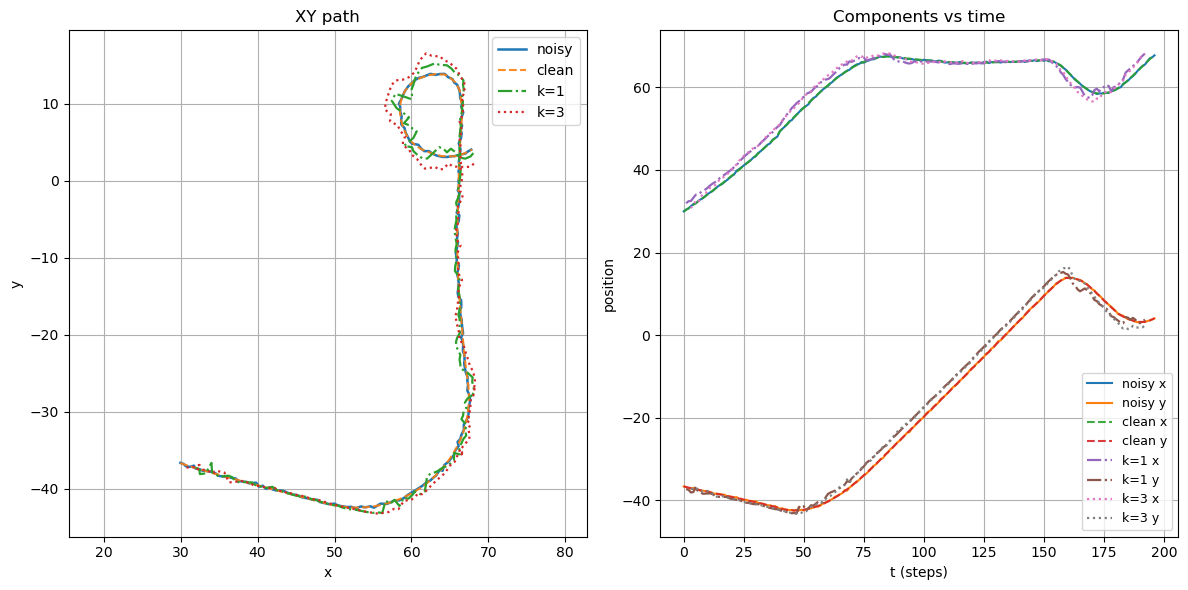

In [71]:
from src.visual.visual_tools import plot_trajectories_with_predictions_shifted

idx = 17
class_name = "IMM_AllModerateNoise_obs_0.1"
chronos_traj = chronos_predictions_per_trajectory[class_name][idx]
imm_traj = kf_predictions_per_trajectory[class_name][idx]
noisy = imm_data[class_name]["X"][idx]
real = imm_data[class_name]["Y"][idx]
plot_trajectories_with_predictions_shifted(noisy, real, [(imm_traj, 1), (chronos_traj, 3)])

k = 1

Class                          |  Avg IMM MSE |  Avg Chronos | Trajectory Wins (Chronos vs IMM)
----------------------------------------------------------------------------------------------------
IMM_AllHighNoise_obs_0.1       |     0.144130 |     0.949934 | Chronos:  0/20 (  0.0%) | IMM: 20/20
IMM_AllHighNoise_obs_0.5       |     0.504142 |     0.929516 | Chronos:  0/20 (  0.0%) | IMM: 20/20
IMM_AllHighNoise_obs_0.8       |     0.599748 |     0.822718 | Chronos:  0/20 (  0.0%) | IMM: 20/20
IMM_AllLowNoise_obs_0.1        |     0.123416 |     0.919354 | Chronos:  0/20 (  0.0%) | IMM: 20/20
IMM_AllLowNoise_obs_0.5        |     0.515649 |     0.884524 | Chronos:  0/20 (  0.0%) | IMM: 20/20
IMM_AllLowNoise_obs_0.8        |     0.571533 |     0.778215 | Chronos:  0/20 (  0.0%) | IMM: 20/20
IMM_AllModerateNoise_obs_0.1   |     0.136659 |     0.843524 | Chronos:  0/20 (  0.0%) | IMM: 20/20
IMM_AllModerateNoise_obs_0.5   |     0.555260 |     0.847936 | Chronos:  0/20 (  0.0%) | IMM: 20/20
IMM_AllModerateNoise_obs_0.8   |     0.584699 |     0.826206 | Chronos:  0/20 (  0.0%) | IMM: 20/20
IMM_HighCV_LowCA_obs_0.1       |     0.104129 |     0.904618 | Chronos:  0/20 (  0.0%) | IMM: 20/20
IMM_HighCV_LowCA_obs_0.5       |     0.542708 |     0.890197 | Chronos:  0/20 (  0.0%) | IMM: 20/20
IMM_HighCV_LowCA_obs_0.8       |     0.603385 |     0.837879 | Chronos:  0/20 (  0.0%) | IMM: 20/20
IMM_LowCV_HighCA_obs_0.1       |     0.157192 |     0.875730 | Chronos:  0/20 (  0.0%) | IMM: 20/20
IMM_LowCV_HighCA_obs_0.5       |     0.511092 |     0.853906 | Chronos:  0/20 (  0.0%) | IMM: 20/20
IMM_LowCV_HighCA_obs_0.8       |     0.563194 |     0.847162 | Chronos:  0/20 (  0.0%) | IMM: 20/20
====================================================================================================

Class-level summary (by majority wins):
  Chronos wins majority in: 0/15 classes (0.0%)
  IMM wins majority in: 15/15 classes (100.0%)

k = 5

Class                          |  Avg IMM MSE |  Avg Chronos | Trajectory Wins (Chronos vs IMM)
----------------------------------------------------------------------------------------------------
IMM_AllHighNoise_obs_0.1       |     0.050074 |     0.162283 | Chronos:  0/20 (  0.0%) | IMM: 20/20
IMM_AllHighNoise_obs_0.5       |     0.155330 |     0.316173 | Chronos:  0/20 (  0.0%) | IMM: 20/20
IMM_AllHighNoise_obs_0.8       |     0.321778 |     0.516975 | Chronos:  0/20 (  0.0%) | IMM: 20/20
IMM_AllLowNoise_obs_0.1        |     0.043591 |     0.152299 | Chronos:  0/20 (  0.0%) | IMM: 20/20
IMM_AllLowNoise_obs_0.5        |     0.160614 |     0.355647 | Chronos:  0/20 (  0.0%) | IMM: 20/20
IMM_AllLowNoise_obs_0.8        |     0.255113 |     0.494020 | Chronos:  0/20 (  0.0%) | IMM: 20/20
IMM_AllModerateNoise_obs_0.1   |     0.034364 |     0.134503 | Chronos:  0/20 (  0.0%) | IMM: 20/20
IMM_AllModerateNoise_obs_0.5   |     0.145946 |     0.341323 | Chronos:  0/20 (  0.0%) | IMM: 20/20
IMM_AllModerateNoise_obs_0.8   |     0.282295 |     0.511031 | Chronos:  0/20 (  0.0%) | IMM: 20/20
IMM_HighCV_LowCA_obs_0.1       |     0.049717 |     0.147684 | Chronos:  0/20 (  0.0%) | IMM: 20/20
IMM_HighCV_LowCA_obs_0.5       |     0.166598 |     0.332192 | Chronos:  0/20 (  0.0%) | IMM: 20/20
IMM_HighCV_LowCA_obs_0.8       |     0.289134 |     0.484121 | Chronos:  0/20 (  0.0%) | IMM: 20/20
IMM_LowCV_HighCA_obs_0.1       |     0.043270 |     0.148238 | Chronos:  0/20 (  0.0%) | IMM: 20/20
IMM_LowCV_HighCA_obs_0.5       |     0.179648 |     0.373186 | Chronos:  0/20 (  0.0%) | IMM: 20/20
IMM_LowCV_HighCA_obs_0.8       |     0.309804 |     0.538152 | Chronos:  0/20 (  0.0%) | IMM: 20/20
====================================================================================================
